In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
#We will use the AdamW optimizer from tensorflow/models to fine-tune BERT.
!pip install -q -U tf-models-official==2.7.0
!pip install -U tfds-nightly

In [4]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [12]:
# Next, configure TFHub to read checkpoints directly from TFHub's Cloud Storage buckets. 
# This is only recommended when running TFHub models on TPU.
# Without this setting TFHub would download the compressed file and extract the checkpoint locally. 
# Attempting to load from these local files will fail with the following error:
# Without this setting TFHub would download the compressed file and extract the checkpoint locally. 
# Attempting to load from these local files will fail with the following error:

# InvalidArgumentError: Unimplemented: File system scheme '[local]' not implemented
# This is because the TPU can only read directly from Cloud Storage buckets
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"


In [13]:
# Connect to the TPU worker
# The following code connects to the TPU worker and 
# changes TensorFlow's default device to the CPU device on the TPU worker. 
# It also defines a TPU distribution strategy that you will use to distribute 
# model training onto the 8 separate TPU cores available on this one TPU worker. 
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')


In [17]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  
map_name_to_handle = {'bert_en_uncased_L-12_H-768_A-12':'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'}
map_model_to_preprocess = {'bert_en_uncased_L-12_H-768_A-12':'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)
    


BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [18]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


In [19]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(10))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 10)
Word Ids       :  tf.Tensor([  101  7592 23435 12314   999   102  7592 23435 12314   102], shape=(10,), dtype=int32)
Shape Mask     :  (1, 10)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1], shape=(10,), dtype=int32)
Shape Type Ids :  (1, 10)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1], shape=(10,), dtype=int32)


In [20]:
mask_ids=text_preprocessed["input_mask"].numpy()
token_ids=text_preprocessed["input_word_ids"].numpy()
type_ids=text_preprocessed["input_type_ids"].numpy()
print(mask_ids,"Shape: =======>",mask_ids.shape)
print(token_ids,"shape: ====>",token_ids.shape)
print(type_ids,"shape: =========>",type_ids.shape)

[[1 1 1 1 1 1 1 1 1 1]] Shape: =======> (1, 10)
[[  101  7592 23435 12314   999   102  7592 23435 12314   102]] shape: ====> (1, 10)
[[0 0 0 0 0 0 1 1 1 1]] shape: =========> (1, 10)


In [22]:
  #The function below makes a preprocessing model.
  #Returns Model mapping string features to BERT inputs.

  # Args:
  #   sentence_features: a list with the names of string-valued features.
  #   seq_length: an integer that defines the sequence length of BERT inputs.

  # Returns:
  #   A Keras Model that can be called on a list or dict of string Tensors
  #   (with the order or names, resp., given by sentence_features) and
  #   returns a dict of tensors for input to BERT.
  #

def make_bert_preprocess_model(sentence_features, seq_length=128):
  
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(tfhub_handle_preprocess)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)

In [23]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


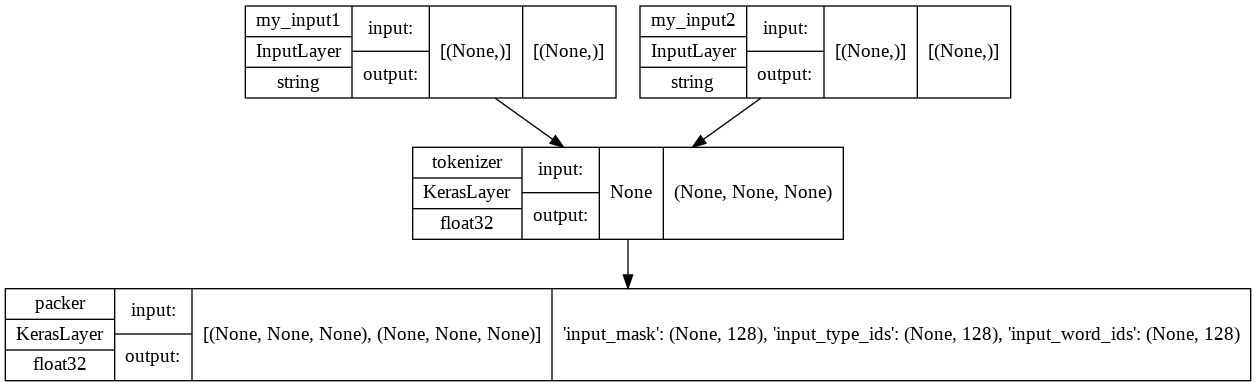

In [24]:
tf.keras.utils.plot_model(test_preprocess_model, show_shapes=True, show_dtype=True)

In [25]:
# To apply the preprocessing in all the inputs from the dataset, 
# we will use the `map` function from the dataset.

AUTOTUNE = tf.data.AUTOTUNE


def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

In [26]:
# Define a model here below
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

In [27]:
# Let's try running the model on some preprocessed inputs.

test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.2772915  0.52531683]], shape=(1, 2), dtype=float32)


In [ ]:
# Now we are going to use a TensorFlow DataSet from the [GLUE](https://www.tensorflow.org/datasets/catalog/glue) benchmark suite.
# Colab lets you download these small datasets to the local filesystem, and the code below reads them entirely into memory, 
# because the separate TPU worker host cannot access the local filesystem of the colab runtime.
# For bigger datasets, you'll need to create your own [Google Cloud Storage](https://cloud.google.com/storage) bucket and 
# have the TPU worker read the data from there. 
# You can learn more in the [TPU guide](https://www.tensorflow.org/guide/tpu#input_datasets).
# It's recommended to start with the CoLa dataset (for single sentence) or MRPC (for multi sentence) 
# since these are small and don't take long to fine tune.

In [28]:
tfds_name = 'glue/cola'  #@param ['glue/cola', 'glue/sst2', 'glue/mrpc', 'glue/qqp', 'glue/mnli', 'glue/qnli', 'glue/rte', 'glue/wnli']

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/8551 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/cola/2.0.0.incompleteEAJWF8/glue-train.tfrecord*...:   0%|          | 0/8…

Generating validation examples...:   0%|          | 0/1043 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/cola/2.0.0.incompleteEAJWF8/glue-validation.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/1063 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/cola/2.0.0.incompleteEAJWF8/glue-test.tfrecord*...:   0%|          | 0/10…

Dataset glue downloaded and prepared to ~/tensorflow_datasets/glue/cola/2.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)



In [29]:
# The dataset also determines the problem type (classification or regression) and 
# the appropriate loss function for training.
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  if glue_task == 'glue/cola':
    metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
  else:
    metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metrics, loss

In [ ]:
# ## Train your model

# Finally, you can train the model end-to-end on the dataset you chose.

# ### Distribution

# Recall the set-up code at the top, which has connected the colab runtime to
# a TPU worker with multiple TPU devices. To distribute training onto them, 
# we will create and compile our main Keras model within the scope of the TPU distribution strategy. 
# (For details, see [Distributed training with Keras](https://www.tensorflow.org/tutorials/distribute/keras).)
# Preprocessing, on the other hand, runs on the CPU of the worker host, not the TPUs, 
# so the Keras model for preprocessing as well as the training and 
# validation datasets mapped with it are built outside the distribution strategy scope. 
# The call to `Model.fit()` will take care of distributing the passed-in dataset to the model replicas.

# Note: The single TPU worker host already has the resource objects 
# (think: a lookup table) needed for tokenization. 
# Scaling up to multiple workers requires use of `Strategy.experimental_distribute_datasets_from_function` 
# with a function that loads the preprocessing model separately onto each worker.

# ### Optimizer

# Fine-tuning follows the optimizer set-up from BERT pre-training 
# (as in [Classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)): 
# It uses the AdamW optimizer with a linear decay of a notional initial learning rate,
#  prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). 
# In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [31]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

In [ ]:
# ## Export for inference

# You will create a final model that has the preprocessing part and the fine-tuned BERT we've just created.

# At inference time, preprocessing needs to be part of the model 
# (because there is no longer a separate input queue as for training data that does it). 
# Preprocessing is not just computation; it has its own resources (the vocab table) 
# that must be attached to the Keras Model that is saved for export.
# This final assembly is what will be saved.

# You are going to save the model on colab and later 
# you can download to keep it for the future (**View -> Table of contents -> Files**).

main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

In [ ]:
# ## Test the model
# The final step is testing the results of your exported model.
# Just to make some comparison, let's reload the model and test it using some inputs from the test split from the dataset.
# Note: The test is done on the colab host, not the TPU worker that it has connected to, 
# so it appears below with explicit device placements. You can omit those when loading the SavedModel elsewhere.


In [ ]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)


In [ ]:
#optional
##Utility code
#@title Utility methods

def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs


def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs


def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  if dataset_name == 'glue/cola':
    print('sentence:', test[0].numpy())
    if bert_result_class == 1:
      print('This sentence is acceptable')
    else:
      print('This sentence is unacceptable')

  elif dataset_name == 'glue/sst2':
    print('sentence:', test[0])
    if bert_result_class == 1:
      print('This sentence has POSITIVE sentiment')
    else:
      print('This sentence has NEGATIVE sentiment')

  elif dataset_name == 'glue/mrpc':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Are a paraphrase')
    else:
      print('Are NOT a paraphrase')

  elif dataset_name == 'glue/qqp':
    print('question1:', test[0])
    print('question2:', test[1])
    if bert_result_class == 1:
      print('Questions are similar')
    else:
      print('Questions are NOT similar')

  elif dataset_name == 'glue/mnli':
    print('premise   :', test[0])
    print('hypothesis:', test[1])
    if bert_result_class == 1:
      print('This premise is NEUTRAL to the hypothesis')
    elif bert_result_class == 2:
      print('This premise CONTRADICTS the hypothesis')
    else:
      print('This premise ENTAILS the hypothesis')

  elif dataset_name == 'glue/qnli':
    print('question:', test[0])
    print('sentence:', test[1])
    if bert_result_class == 1:
      print('The question is NOT answerable by the sentence')
    else:
      print('The question is answerable by the sentence')

  elif dataset_name == 'glue/rte':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  elif dataset_name == 'glue/wnli':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  print('BERT raw results:', bert_result[0])
  print()

In [ ]:
# Tesf
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(5):
    if len(sentence_features) == 1:
      result = reloaded_model(test_row[0])
    else:
      result = reloaded_model(list(test_row))

    print_bert_results(test_row, result, tfds_name)



In [ ]:
# If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), 
# remember that it will call your SavedModel through one of its named signatures. 
# Notice there are some small differences in the input. In Python, you can test them as follows:
with tf.device('/job:localhost'):
  serving_model = reloaded_model.signatures['serving_default']
  for test_row in test_dataset.shuffle(1000).map(prepare_serving).take(5):
    result = serving_model(**test_row)
    # The 'prediction' key is the classifier's defined model name.
    print_bert_results(list(test_row.values()), result['prediction'], tfds_name)


In [ ]:
# We did it! our saved model could be used for serving or simple inference in a process, 
# with a simpler api with less code and easier to maintain.
# ## Next Steps

# Now that we've tried one of the base BERT models, 
# you can try other ones to achieve more accuracy or maybe with smaller model versions.
# You can also try in other datasets.